<a href="https://colab.research.google.com/github/dreamboat26/Agent-AI/blob/main/af/examples/predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
unified_memory = True #@param {type:"boolean"}
import os, time, gc
if unified_memory:
  ENV = {"TF_FORCE_UNIFIED_MEMORY":"1", "XLA_PYTHON_CLIENT_MEM_FRACTION":"4.0"}
  for k,v in ENV.items(): os.environ[k] = v
if not os.path.isdir("params"):
  # get code
  print("installing ColabDesign")
  os.system("(mkdir params; apt-get install aria2 -qq; \
  aria2c -q -x 16 https://storage.googleapis.com/alphafold/alphafold_params_2022-12-06.tar; \
  tar -xf alphafold_params_2022-12-06.tar -C params; touch params/done.txt )&")

  os.system("pip -q install git+https://github.com/sokrypton/ColabDesign.git@gamma")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabdesign colabdesign")
  os.system("wget https://raw.githubusercontent.com/sokrypton/ColabFold/main/colabfold/colabfold.py -O colabfold_utils.py")
  #os.system("wget https://raw.githubusercontent.com/sokrypton/ColabFold/beta/colabfold/mmseqs/api.py")

  # install hhsuite
  print("installing HHsuite")
  os.makedirs("hhsuite", exist_ok=True)
  os.system(f"curl -fsSL https://github.com/soedinglab/hh-suite/releases/download/v3.3.0/hhsuite-3.3.0-SSE2-Linux.tar.gz | tar xz -C hhsuite/")

  # download params
  if not os.path.isfile("params/done.txt"):
    print("downloading AlphaFold params")
    while not os.path.isfile("params/done.txt"):
      time.sleep(5)
if "hhsuite" not in os.environ['PATH']:
  os.environ['PATH'] += ":hhsuite/bin:hhsuite/scripts"

import re, tempfile
from IPython.display import HTML
from google.colab import files
import numpy as np
from colabdesign import mk_af_model, clear_mem
from colabdesign.af.contrib import predict
from colabdesign.af.contrib.cyclic import add_cyclic_offset
from colabdesign.shared.protein import _np_rmsd, _np_kabsch
from colabdesign.shared.plot import plot_pseudo_3D, pymol_cmap
import colabdesign.af.contrib.extended_ptm as extended_ptm

import jax
import jax.numpy as jnp
from colabfold_utils import run_mmseqs2
import matplotlib.pyplot as plt
import string
import numpy as np

def clear_mem():
  backend = jax.lib.xla_bridge.get_backend()
  for buf in backend.live_buffers(): buf.delete()

def get_pdb(pdb_code=""):
  if pdb_code is None or pdb_code == "":
    upload_dict = files.upload()
    pdb_string = upload_dict[list(upload_dict.keys())[0]]
    with open("tmp.pdb","wb") as out: out.write(pdb_string)
    return "tmp.pdb"
  elif os.path.isfile(pdb_code):
    return pdb_code
  elif len(pdb_code) == 4:
    os.makedirs("tmp",exist_ok=True)
    os.system(f"wget -qnc https://files.rcsb.org/download/{pdb_code}.cif -P tmp/")
    return f"tmp/{pdb_code}.cif"
  else:
    os.makedirs("tmp",exist_ok=True)
    os.system(f"wget -qnc https://alphafold.ebi.ac.uk/files/AF-{pdb_code}-F1-model_v4.pdb -P tmp/")
    return f"tmp/AF-{pdb_code}-F1-model_v4.pdb"

def run_hhalign(query_sequence, target_sequence, query_a3m=None, target_a3m=None):
  with tempfile.NamedTemporaryFile() as tmp_query, \
  tempfile.NamedTemporaryFile() as tmp_target, \
  tempfile.NamedTemporaryFile() as tmp_alignment:
    if query_a3m is None:
      tmp_query.write(f">Q\n{query_sequence}\n".encode())
      tmp_query.flush()
      query_a3m = tmp_query.name
    if target_a3m is None:
      tmp_target.write(f">T\n{target_sequence}\n".encode())
      tmp_target.flush()
      target_a3m = tmp_target.name
    os.system(f"hhalign -hide_cons -i {query_a3m} -t {target_a3m} -o {tmp_alignment.name}")
    X, start_indices = predict.parse_hhalign_output(tmp_alignment.name)
  return X, start_indices

def run_do_not_align(query_sequence, target_sequence, **arg):
  return [query_sequence,target_sequence],[0,0]

def run_hhfilter(input, output, id=90, qid=10):
  os.system(f"hhfilter -id {id} -qid {qid} -i {input} -o {output}")

@jax.jit
def get_coevolution(X):
  '''given one-hot encoded MSA, return contacts'''
  Y = jax.nn.one_hot(X,22)
  N,L,A = Y.shape
  Y_flat = Y.reshape(N,-1)
  # covariance
  c = jnp.cov(Y_flat.T)

  # inverse covariance
  shrink = 4.5/jnp.sqrt(N) * jnp.eye(c.shape[0])
  ic = jnp.linalg.inv(c + shrink)

  # partial correlation coefficient
  ic_diag = jnp.diag(ic)
  pcc = ic / jnp.sqrt(ic_diag[:,None] * ic_diag[None,:])

  raw = jnp.sqrt(jnp.square(pcc.reshape(L,A,L,A)[:,:20,:,:20]).sum((1,3)))
  i = jnp.arange(L)
  raw = raw.at[i,i].set(0)
  # do apc
  ap = raw.sum(0,keepdims=True) * raw.sum(1,keepdims=True) / raw.sum()
  return (raw - ap).at[i,i].set(0)

def plot_3D(aux, Ls, file_name, show=False):
  plt.figure(figsize=(10,5))
  xyz = aux["atom_positions"][:,1]
  xyz = xyz @ _np_kabsch(xyz, xyz, return_v=True, use_jax=False)
  ax = plt.subplot(1,2,1)
  if len(Ls) > 1:
    plt.title("chain")
    c = np.concatenate([[n]*L for n,L in enumerate(Ls)])
    plot_pseudo_3D(xyz=xyz, c=c, cmap=pymol_cmap, cmin=0, cmax=39, Ls=Ls, ax=ax)
  else:
    plt.title("length")
    plot_pseudo_3D(xyz=xyz, Ls=Ls, ax=ax)
  plt.axis(False)
  ax = plt.subplot(1,2,2)
  plt.title("plddt")
  plot_pseudo_3D(xyz=xyz, c=aux["plddt"], cmin=0.5, cmax=0.9, Ls=Ls, ax=ax)
  plt.axis(False)
  plt.savefig(file_name, dpi=200, bbox_inches='tight')
  plt.show() if show else plt.close()

jobname test_a5e17
length=[59] copies=1
getting unpaired MSA


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:01 remaining: 00:00]


parsing msas
gathering info
filtering sequences
selecting final sequences


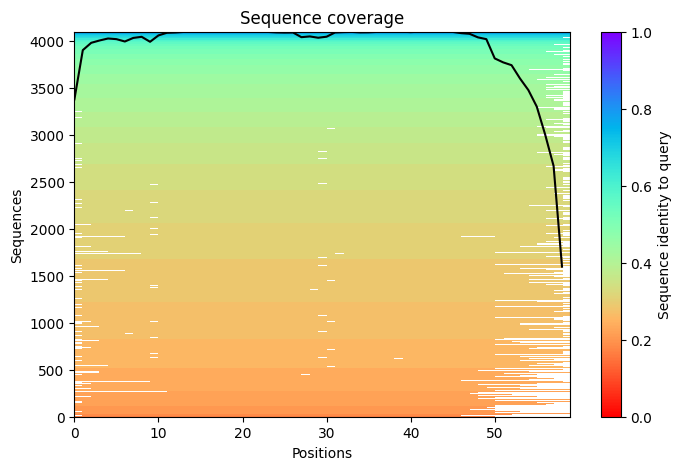

GC 5377


In [5]:
#@title prep_inputs
sequence = "PIAQIHILEGRSDEQKETLIREVSEAISRSLDAPLTSVRVIITEMAKGHFGIGGELASK" #@param {type:"string"}
jobname = "test" #@param {type:"string"}

copies = 1 #@param ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"] {type:"raw"}
#@markdown ----
#@markdown **MSA options**
msa_method = "mmseqs2" #@param ["mmseqs2","single_sequence", "custom_fas", "custom_a3m", "custom_sto"]
pair_mode = "unpaired_paired" #@param ["unpaired_paired","paired","unpaired"] {type:"string"}
#@markdown filtering options
cov = 75 #@param ["0", "25", "50", "75", "90", "99"] {type:"raw"}
id = 90 #@param ["90", "100"] {type:"raw"}
qid = 0 #@param ["0", "10", "15", "20", "30"] {type:"raw"}
do_not_filter = False #@param {type:"boolean"}

#@markdown ----
#@markdown **Templates options**
template_mode = "none" #@param ["none", "mmseqs2", "custom"] {type:"string"}
use_templates = template_mode in ["mmseqs2","custom"]
pdb = "" #@param {type:"string"}
chain = "A" #@param {type:"string"}
rm_template_seq = False #@param {type:"boolean"}
propagate_to_copies = True #@param {type:"boolean"}
do_not_align = False #@param {type:"boolean"}
rm_sidechain = rm_sequence = rm_template_seq

# filter options
sequence = sequence.upper()
sequence = re.sub("[^A-Z:/()]", "", sequence.upper())
sequence = re.sub("\(",":(", sequence)
sequence = re.sub("\)","):", sequence)
sequence = re.sub(":+",":",sequence)
sequence = re.sub("/+","/",sequence)
sequence = re.sub("^[:/]+","",sequence)
sequence = re.sub("[:/]+$","",sequence)
jobname = re.sub(r'\W+', '', jobname)

# process sequence
sequences = sequence.split(":")
u_sequences = predict.get_unique_sequences(sequences)
u_cyclic = [x.startswith("(") for x in u_sequences]
u_sub_lengths = [[len(y) for y in x.split("/")] for x in u_sequences]
u_sequences = [x.replace("(","").replace(")","").replace("/","") for x in u_sequences]
if len(sequences) > len(u_sequences):
  print("WARNING: use copies to define homooligomers")
u_lengths = [len(x) for x in u_sequences]
sub_seq = "".join(u_sequences)
seq = sub_seq * copies

jobname = f"{jobname}_{predict.get_hash(seq)[:5]}"
def check(folder): return os.path.exists(folder)
if check(jobname):
  n = 0
  while check(f"{jobname}_{n}"): n += 1
  jobname = f"{jobname}_{n}"

print("jobname",jobname)
print(f"length={u_lengths} copies={copies}")

input_opts = {"sequence":u_sequences,
              "copies":copies,
              "msa_method":msa_method,
              "pair_mode":pair_mode,
              "do_not_filter":do_not_filter,
              "cov":cov,
              "id":id,
              "template_mode":template_mode,
              "propagate_to_copies":propagate_to_copies}

def run_mmseqs2_wrapper(*args, **kwargs):
  kwargs['user_agent'] = "colabdesign/gamma"
  return run_mmseqs2(*args, **kwargs)

##################
# GET MSA
##################
os.makedirs(jobname, exist_ok=True)

Ls = [len(x) for x in u_sequences]
if msa_method == "mmseqs2":
  msa, deletion_matrix = predict.get_msa(u_sequences, jobname,
    mode=pair_mode,
    cov=cov, id=id, qid=qid, max_msa=4096,
    do_not_filter=do_not_filter,
    mmseqs2_fn=run_mmseqs2_wrapper,
    hhfilter_fn=run_hhfilter)

elif msa_method == "single_sequence":
  with open(f"{jobname}/msa.a3m","w") as a3m:
    a3m.write(f">{jobname}\n{sub_seq}\n")
  msa, deletion_matrix = predict.parse_a3m(f"{jobname}/msa.a3m")

else:
  msa_format = msa_method.split("_")[1]
  print(f"upload {msa_method}")
  msa_dict = files.upload()
  lines = []
  for k,v in msa_dict.items():
    lines += v.decode().splitlines()
  input_lines = []
  for line in lines:
    line = line.replace("\x00","")
    if len(line) > 0 and not line.startswith('#'):
      input_lines.append(line)
  with open(f"{jobname}/msa.{msa_format}","w") as msa:
    msa.write("\n".join(input_lines))
  if msa_format != "a3m":
    os.system(f"perl hhsuite/scripts/reformat.pl {msa_format} a3m {jobname}/msa.{msa_format} {jobname}/msa.a3m")
  if do_not_filter:
    os.system(f"hhfilter -qid 0 -id 100 -cov 0 -i {jobname}/msa.a3m -o {jobname}/msa.filt.a3m")
  else:
    os.system(f"hhfilter -qid {qid} -id {id} -cov {cov} -i {jobname}/msa.a3m -o {jobname}/msa.filt.a3m")
  msa, deletion_matrix = predict.parse_a3m(f"{jobname}/msa.filt.a3m")

if len(msa) > 1:
  predict.plot_msa(msa, Ls)
  plt.savefig(f"{jobname}/msa_feats.png", dpi=200, bbox_inches='tight')
  plt.show()

##################
if use_templates:
  print("aligning template")
  template_msa = f"{jobname}/msa.a3m"
  if template_mode == "mmseqs2":
    predict.get_msa(u_sequences, jobname,
      mode="unpaired",
      mmseqs2_fn=run_mmseqs2_wrapper,
      do_not_filter=True,
      do_not_return=True,
      output_a3m=f"{jobname}/msa_tmp.a3m")
    template_msa = f"{jobname}/msa_tmp.a3m"
    if not propagate_to_copies and copies > 1:
      new_msa = []
      with open(template_msa, "r") as handle:
        for line in handle:
          if not line.startswith(">"):
            new_msa.append(line.rstrip())
      with open(template_msa, "w") as handle:
        for n,seq in enumerate(new_msa):
          handle.write(f">{n}\n{seq*copies}\n")

    templates = {}
    print("ID\tpdb\tcid\tevalue")
    for line in open(f"{jobname}/msa/_env/pdb70.m8","r"):
      p = line.rstrip().split()
      M,target_id,qid,e_value = p[0],p[1],p[2],p[10]
      M = int(M)
      if M not in templates:
        templates[M] = []
      if len(templates[M]) < 4:
        print(f"{int(M)}\t{target_id}\t{qid}\t{e_value}")
        templates[M].append(target_id)
    if len(templates) == 0:
      use_templates = False
      print("ERROR: no templates found...")
    else:
      Ms = sorted(list(templates.keys()))
      pdbs,chains = [],[]
      for M in Ms:
        for n,target_id in enumerate(templates[M]):
          pdb_id,chain_id = target_id.split("_")
          if len(pdbs) < n+1:
            pdbs.append([])
            chains.append([])
          pdbs[n].append(pdb_id)
          chains[n].append(chain_id)
      print(pdbs)
  else:
    pdbs,chains = [pdb],[chain]

if use_templates:
  input_opts.update({"pdbs":pdbs, "chains":chains})
  batches = []
  for pdb,chain in zip(pdbs,chains):
    query_seq = "".join(u_sequences)
    batch = predict.get_template_feats(pdb, chain,
      query_seq=query_seq,
      query_a3m=template_msa,
      copies=copies,
      propagate_to_copies=propagate_to_copies,
      use_seq=not rm_sequence,
      get_pdb_fn=get_pdb,
      align_fn=run_do_not_align if do_not_align else run_hhalign)
    batches.append(batch)

  # for display
  plt.figure(figsize=(3*len(batches),3))
  for n,batch in enumerate(batches):
    plt.subplot(1,len(batches),n+1)
    plt.title(f"template features {n+1}")
    dgram = batch["dgram"].argmax(-1).astype(float)
    dgram[batch["dgram"].sum(-1) == 0] = np.nan
    Ln = dgram.shape[0]
    plt.imshow(dgram, extent=(0, Ln, Ln, 0))
    predict.plot_ticks(Ls * copies)
  plt.savefig(f"{jobname}/template_feats.png", dpi=200, bbox_inches='tight')
  plt.show()
else:
  batches = [None]

################
print("GC",gc.collect())

In [6]:
#@title pre_analysis (optional)
analysis = "none" # @param ["none", "coevolution"]
dpi = 100 # @param ["100", "200", "300"] {type:"raw"}
if analysis == "coevolution":
  coevol = get_coevolution(msa)
  plt.figure(figsize=(5,5), dpi=dpi)
  plt.title("coevolution")
  plt.imshow(coevol)
  plt.axis(False)
  plt.show()

In [7]:
#@title prep_model
#@markdown Model options
model_type = "auto" #@param ["monomer (ptm)", "pseudo_multimer (v3)", "multimer (v3)", "auto"]
rank_by = "auto" #@param ["auto", "plddt", "ptm"]
debug = False #@param {type:"boolean"}
use_initial_guess = False

#@markdown MSA options
num_msa = 512 #@param ["1","2","4","8","16","32", "64", "128", "256", "512"] {type:"raw"}
num_extra_msa = 1024 #@param ["1","2","4","8","16","32", "64", "128", "256", "512", "1024","2048","4096"] {type:"raw"}
use_cluster_profile = True #@param {type:"boolean"}

#@markdown Extended metrics (calculate pairwise ipTM, actifpTM and chain pTM)
calc_extended_ptm = True #@param {type:"boolean"}
if len(Ls) == 1 and copies == 1:
  calc_extended_ptm = False

if calc_extended_ptm:
  debug=True

if model_type == "monomer (ptm)":
  use_multimer = False
  pseudo_multimer = False
elif model_type == "multimer (v3)":
  use_multimer = True
  pseudo_multimer = False
elif model_type == "pseudo_multimer (v3)":
  use_multimer = True
  pseudo_multimer = True
elif len(u_lengths) > 1 or copies > 1:
  use_multimer = True
  pseudo_multimer = False
else:
  use_multimer = False
  pseudo_multimer = False

if rank_by == "auto":
  rank_by = "multi" if (len(u_lengths) > 1 or copies > 1) else "plddt"

model_opts = {"num_msa":num_msa,
              "num_extra_msa":num_extra_msa,
              "num_templates":len(batches),
              "use_cluster_profile":use_cluster_profile,
              "use_multimer":use_multimer,
              "pseudo_multimer":pseudo_multimer,
              "use_templates":use_templates,
              "use_batch_as_template":False,
              "use_dgram":True,
              "protocol":"hallucination",
              "best_metric":rank_by,
              "optimize_seq":False,
              "debug":debug,
              "clear_prev":False}

# initialize the model
if "af" in dir():
  # reuse the model and/or params if already initialized
  if model_opts != model_opts_:
    if model_opts["use_multimer"] == af._args["use_multimer"] \
    and model_opts["use_templates"] == af._args["use_templates"]:
      old_params = dict(zip(af._model_names,af._model_params))
    else:
      print("loading alphafold params")
      old_params = {}
      clear_mem()
    af = mk_af_model(old_params=old_params,
                     use_mlm=True, # can be disabled later with 0% masking
                     **model_opts)
    model_opts_ = predict.copy_dict(model_opts)
else:
  print("loading alphafold params")
  af = mk_af_model(use_mlm=True,
                   **model_opts)
  model_opts_ = predict.copy_dict(model_opts)

# prep inputs
af.prep_inputs(u_lengths, copies=copies, seed=0)
print_key = ["plddt","ptm"]
if len(af._lengths) > 1: print_key += ["i_ptm", "multi"]

# for contact map
af.set_opt("con",cutoff=8.0)

# set templates
if use_templates:

  # interchain masking determined by dgram
  af._inputs["interchain_mask"] = np.full_like(af._inputs["interchain_mask"],True)

  af.set_opt(use_initial_guess=use_initial_guess)
  for n,batch in enumerate(batches):
    af.set_template(batch=batch, n=n)
  af.set_opt("template",
             rm_sc=rm_sidechain,
             rm_seq=rm_sequence)
# set msa
af.set_msa(msa, deletion_matrix)

# set chainbreaks
L_prev = 0
for n,l in enumerate(u_sub_lengths * copies):
  for L_i in l[:-1]:
    af._inputs["residue_index"][L_prev+L_i:] += 32
    L_prev += L_i
  L_prev += l[-1]

# set cyclic constraints
i_cyclic = [n for n, c in enumerate(u_cyclic * copies) if c]
if len(i_cyclic) > 0:
  add_cyclic_offset(af,i_cyclic)

loading alphafold params


running prediction
seed=0 model=model_1_ptm recycle=0 plddt=0.964 ptm=0.748
seed=0 model=model_1_ptm recycle=1 plddt=0.963 ptm=0.754 rmsd_tol=0.312


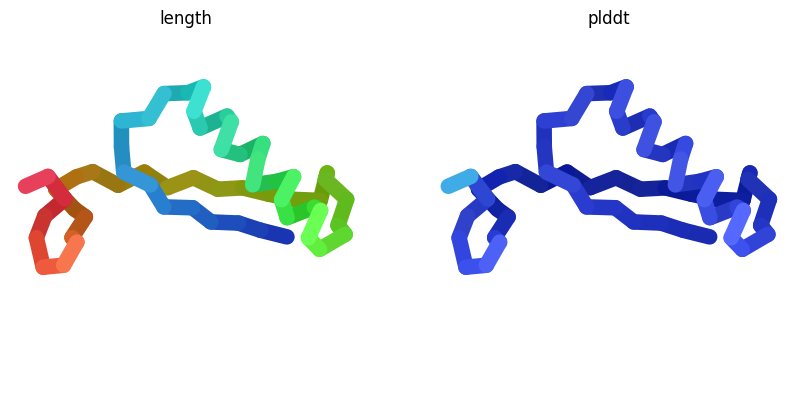

seed=0 model=model_2_ptm recycle=0 plddt=0.968 ptm=0.761
seed=0 model=model_2_ptm recycle=1 plddt=0.969 ptm=0.767 rmsd_tol=0.411


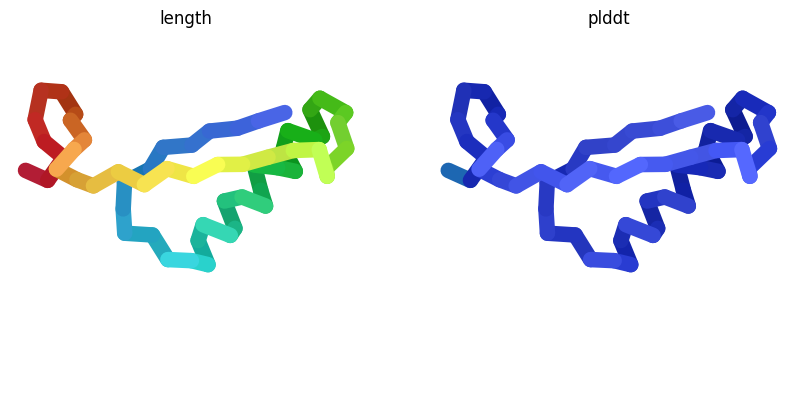

seed=0 model=model_3_ptm recycle=0 plddt=0.970 ptm=0.772
seed=0 model=model_3_ptm recycle=1 plddt=0.974 ptm=0.782 rmsd_tol=0.232


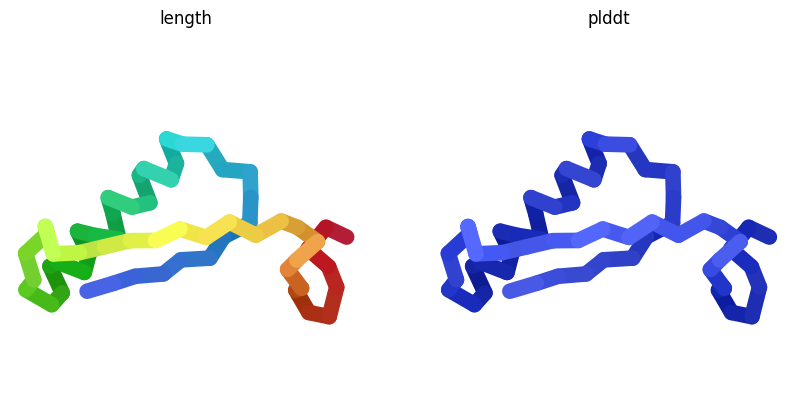

seed=0 model=model_4_ptm recycle=0 plddt=0.972 ptm=0.771
seed=0 model=model_4_ptm recycle=1 plddt=0.973 ptm=0.779 rmsd_tol=0.342


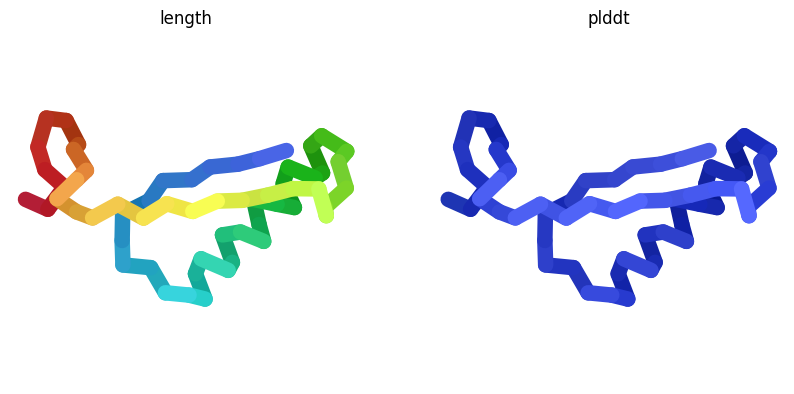

seed=0 model=model_5_ptm recycle=0 plddt=0.973 ptm=0.780
seed=0 model=model_5_ptm recycle=1 plddt=0.966 ptm=0.780 rmsd_tol=0.417


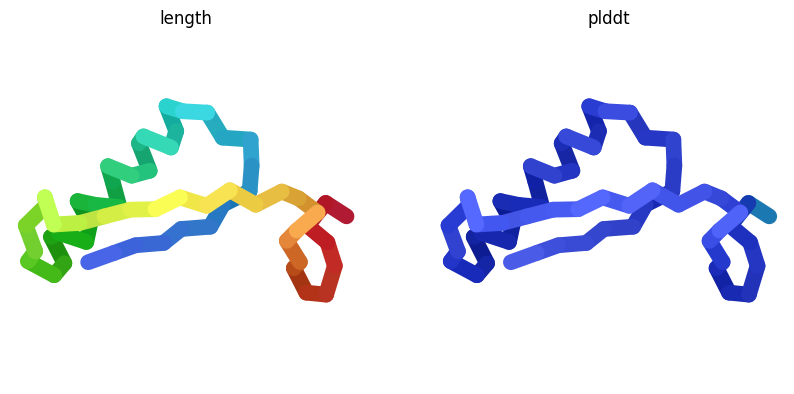

best_tag=model_3_ptm_r1_seed0 seed=0 model=model_3_ptm recycle=1 plddt=0.974 ptm=0.782 rmsd_tol=0.232
GC 47414
CPU times: user 56min 46s, sys: 57.3 s, total: 57min 43s
Wall time: 34min 21s


In [8]:
%%time
#@title run_alphafold
#@markdown Model options
model = "all" #@param ["1", "2", "3", "4", "5", "all"]
num_recycles = 6 #@param ["0", "1", "2", "3", "6", "12", "24"] {type:"raw"}
recycle_early_stop_tolerance = 0.5 #@param ["0.0", "0.5", "1.0"] {type:"raw"}
select_best_across_recycles = False #@param {type:"boolean"}
#@markdown Stochastic options
use_mlm = True #@param {type:"boolean"}
use_dropout = False #@param {type:"boolean"}
seed = 0 #@param {type:"raw"}
num_seeds = 1 #@param ["1", "2", "4", "8", "16", "32", "64", "128"] {type:"raw"}
#@markdown extras
show_images = True #@param {type:"boolean"}

run_opts = {"seed":seed,
            "use_mlm":use_mlm,
            "use_dropout":use_dropout,
            "num_recycles":num_recycles,
            "model":model,
            "use_initial_guess":use_initial_guess,
            "select_best_across_recycles":select_best_across_recycles,
            "recycle_early_stop_tolerance":recycle_early_stop_tolerance}

# decide which models to use
if model == "all": models = af._model_names
else: models = [af._model_names[int(model) - 1]]

# set options
af.set_opt("mlm", replace_fraction=0.15 if use_mlm else 0.0)

pdb_path = f"{jobname}/pdb"
os.makedirs(pdb_path, exist_ok=True)

# keep track of results
info = []
af._tmp = {"traj":{"seq":[],"xyz":[],"plddt":[],"pae":[]},
           "log":[],"best":{}}

# run
print("running prediction")
with open(f"{jobname}/log.txt","w") as handle:
  # go through all seeds
  seeds = list(range(seed,seed+num_seeds))
  for seed in seeds:
    af.set_seed(seed)
    # go through all models
    for model in models:
      recycle = 0
      af._inputs.pop("prev",None)
      stop_recycle = False
      prev_pos = None
      # go through all recycles
      while recycle < num_recycles + 1:
        print_str = f"seed={seed} model={model} recycle={recycle}"
        af.predict(dropout=use_dropout, models=[model], verbose=False)

        # set previous inputs
        af._inputs["prev"] = af.aux["prev"]

        # save results
        if len(af._lengths) > 1:
          af.aux["log"]["multi"] = 0.8 * af.aux["log"]["i_ptm"] + 0.2 * af.aux["log"]["ptm"]
        af.save_current_pdb(f"{pdb_path}/{model}_r{recycle}_seed{seed}.pdb")

        # print metrics
        for k in print_key: print_str += f" {k}={af.aux['log'][k]:.3f}"

        # early stop check
        current_pos = af.aux["atom_positions"][:,1]
        if recycle > 0:
          rmsd_tol = _np_rmsd(prev_pos, current_pos, use_jax=False)
          if rmsd_tol < recycle_early_stop_tolerance:
            stop_recycle = True
          print_str += f" rmsd_tol={rmsd_tol:.3f}"
        prev_pos = current_pos
        # print metrics
        print(print_str); handle.write(f"{print_str}\n")

        tag = f"{model}_r{recycle}_seed{seed}"
        if select_best_across_recycles:
          info.append([tag,print_str,af.aux["log"][rank_by]])
          if calc_extended_ptm:
            extended_ptms = extended_ptm.get_chain_and_interface_metrics(af.aux['debug']['outputs'], af._inputs['asym_id'])
            info[-1].extend([extended_ptms['pairwise_iptm'], extended_ptms['pairwise_actifptm'], extended_ptms['per_chain_ptm']])
          af._save_results(save_best=True,
                           best_metric=rank_by, metric_higher_better=True,
                           verbose=False)
          af._k += 1

        recycle += 1
        if stop_recycle: break

      if not select_best_across_recycles:
        info.append([tag,print_str,af.aux["log"][rank_by]])
        if calc_extended_ptm:
          extended_ptms = extended_ptm.get_chain_and_interface_metrics(af.aux['debug']['outputs'], af._inputs['asym_id'])
          info[-1].extend([extended_ptms['pairwise_iptm'], extended_ptms['pairwise_actifptm'], extended_ptms['per_chain_ptm']])
        af._save_results(save_best=True,
                         best_metric=rank_by, metric_higher_better=True,
                         verbose=False)
        af._k += 1

      # save current results
      plot_3D(af.aux, Ls * copies, f"{pdb_path}/{model}_seed{seed}.pdf", show=show_images)
      predict.plot_confidence(af.aux["plddt"]*100, af.aux["pae"], Ls * copies)
      plt.savefig(f"{pdb_path}/{model}_seed{seed}.png", dpi=200, bbox_inches='tight')
      plt.close()

# save best results
rank = np.argsort([x[2] for x in info])[::-1][:5]
print(f"best_tag={info[rank[0]][0]} {info[rank[0]][1]}")

aux_best = af._tmp["best"]["aux"]
af.save_pdb(f"{pdb_path}/best.pdb")
np.savez_compressed(f"{pdb_path}/best.npz",
                    plddt=aux_best["plddt"].astype(np.float16),
                    pae=aux_best["pae"].astype(np.float16),
                    tag=np.array(info[rank[0]][0]),
                    metrics=np.array(info[rank[0]][1]),
                    iptm_pairwise=np.array(info[rank[0]][3]) if len(info[rank[0]]) > 3 else np.array([]),
                    actifptm_pairwise=np.array(info[rank[0]][4]) if len(info[rank[0]]) > 4 else np.array([]),
                    cptm=np.array(info[rank[0]][5]) if len(info[rank[0]]) > 5 else np.array([]))
np.savez_compressed(f"{pdb_path}/all.npz",
                    plddt=np.array(af._tmp["traj"]["plddt"], dtype=np.float16),
                    pae=np.array(af._tmp["traj"]["pae"], dtype=np.float16),
                    tag=np.array([x[0] for x in info]),
                    metrics=np.array([x[1] for x in info]),
                    iptm_pairwise=np.array(info[rank[0]][3]) if len(info[rank[0]]) > 3 else np.array([]),
                    actifptm_pairwise=np.array(info[rank[0]][4]) if len(info[rank[0]]) > 4 else np.array([]),
                    cptm=np.array(info[rank[0]][5]) if len(info[rank[0]]) > 5 else np.array([]))
plot_3D(aux_best, Ls * copies, f"{pdb_path}/best.pdf", show=False)
predict.plot_confidence(aux_best["plddt"]*100, aux_best["pae"], Ls * copies)
plt.savefig(f"{pdb_path}/best.png", dpi=200, bbox_inches='tight')
plt.close()

# garbage collection
print("GC",gc.collect())

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

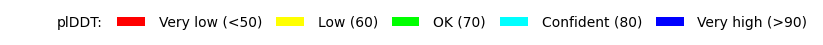

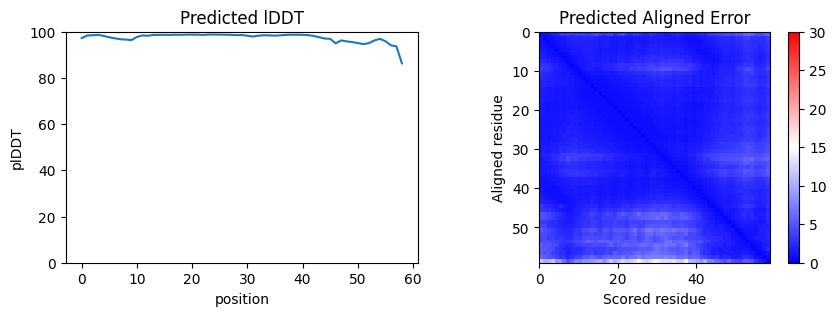

In [9]:
#@title display_best_result (optional) {run: "auto"}
color = "pLDDT" #@param ["pLDDT","chain","rainbow"]
show_sidechains = False #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}
color_HP = True

af.plot_pdb(color=color, show_sidechains=show_sidechains, show_mainchains=show_mainchains, color_HP=color_HP)
predict.plot_plddt_legend().show()
aux_best = af._tmp["best"]["aux"]
predict.plot_confidence(aux_best["plddt"]*100, aux_best["pae"], u_lengths * copies).show()

In [10]:
#@title post_analysis (optional)

analysis = "animate_all_results" # @param ["none", "display_top5_results", "animate_all_results", "coevolution"]
dpi = 100 # @param ["100", "200"] {type:"raw"}

if analysis == "display_top5_results":
  rank = np.argsort([x[2] for x in info])[::-1][:5]
  Ln = sum(Ls)
  plt.figure(figsize=(8,5), dpi=dpi)
  for n in rank:
    plddt = af._tmp["traj"]["plddt"][n] * 100
    plt.plot(plddt, label=info[n][0])
  L_prev = 0
  for L in Ls[:-1]:
    plt.plot([L_prev+L,L_prev+L],[0,100],color="black")
    L_prev += L
  plt.ylim(0,100); plt.ylabel("plddt")
  plt.xlabel('position')
  plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
  plt.savefig(f"{jobname}/top5_plddt.png", dpi=200, bbox_inches='tight')
  plt.show()

  plt.figure(figsize=(25,5), dpi=dpi)
  for i,n in enumerate(rank):
    pae = af._tmp["traj"]["pae"][n]
    plt.subplot(1,5,i+1)
    plt.title(info[n][0])
    plt.imshow(pae,cmap="bwr",vmin=0,vmax=30,extent=(0, Ln, Ln, 0))
    predict.plot_ticks(Ls)
  plt.savefig(f"{jobname}/top5_pae.png", dpi=200, bbox_inches='tight')
  plt.show()

if analysis == "animate_all_results":
  af.animate(dpi=dpi)

if analysis == "coevolution":
  def plot_overlay(true, pred, copies=1):
    if copies > 1:
      L = true.shape[0] // copies
      cmap = true.reshape(copies,L,copies,L)

      # inter
      i,j = np.triu_indices(copies, 1)
      cmap_ = np.maximum(cmap[i,:,j,:].max(0),cmap[j,:,i,:].max(0))

      # intra
      i,j = np.diag_indices(copies)
      cmap = cmap[i,:,j,:].max(0)

      i,j = np.triu_indices(L,1)
      plt.scatter(i,j, c="lightpink", s=20, alpha=np.clip(cmap_[i,j],0,1))
      plt.scatter(j,i, c="lightpink", s=20, alpha=np.clip(cmap_[j,i],0,1))
      true = np.maximum(cmap, cmap_)
    else:
      cmap = true
      L = cmap.shape[0]
      i,j = np.triu_indices(L,1)
    plt.scatter(i,j, c="lightgrey", s=20, alpha=np.clip(cmap[i,j],0,1))
    plt.scatter(j,i, c="lightgrey", s=20, alpha=np.clip(cmap[j,i],0,1))

    pred_6 = pred[np.triu_indices(L,6)]
    true = true[i,j]
    mask = pred[i,j] > np.sort(pred_6)[::-1][L]
    bad = (true < 0.5) & mask
    good = (true > 0.5) & mask
    plt.scatter(i[good], j[good], c="blue", s=5)
    plt.scatter(j[good], i[good], c="blue", s=5)
    plt.scatter(i[bad], j[bad], c="red", s=5)
    plt.scatter(j[bad], i[bad], c="red", s=5)

    plt.xlim(0, L); plt.ylim(0, L)
    plt.gca().set_ylim(plt.gca().get_ylim()[::-1])
    plt.axis('equal')
    plt.axis(False)

  cmap = aux_best["cmap"].copy()
  coevol = get_coevolution(msa)
  plt.figure(figsize=(10,5), dpi=dpi)
  plt.subplot(1,2,1); plt.title("agreement")
  plot_overlay(cmap, coevol, copies=copies)
  plt.subplot(1,2,2); plt.title("coevolution")
  plt.imshow(coevol); plt.axis(False)
  plt.savefig(f"{jobname}/coevolution.png", dpi=200, bbox_inches='tight')
  plt.show()

In [11]:
#@title chainwise_and_pairwise_analysis (optional)
if calc_extended_ptm:
  extended_ptm.plot_chain_pairwise_analysis(info, prefix='model_', fig_path=f"{jobname}/chain_pairwise_ptm.png")
  for x in info:
    print(x)

In [12]:
#@title download_prediction

#@markdown Once this cell has been executed, a zip-archive with
#@markdown the obtained prediction will be automatically downloaded
#@markdown to your computer.

# add settings file
settings_path = f"{jobname}/settings.txt"
with open(settings_path, "w") as text_file:
  if "input_opts" in dir():
    for k,v in input_opts.items():
      text_file.write(f"{k}={v}\n")
  if "model_opts" in dir():
    for k,v in model_opts.items():
      text_file.write(f"{k}={v}\n")
  if "run_opts" in dir():
    for k,v in run_opts.items():
      text_file.write(f"{k}={v}\n")
# --- Download the predictions ---
os.system(f"zip -r {jobname}.zip {jobname}")
files.download(f'{jobname}.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# ==============================================================================
# Agentic System to Generate a Research Report from AlphaFold Plots
# This script takes plots generated from AlphaFold and uses a multimodal LLM
# (LLaVA) to write a research report, running on the CPU.
# ==============================================================================

import os
import zipfile
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch

from transformers import LlavaForConditionalGeneration, LlavaProcessor

# This part simulates the output of your AlphaFold visualization code.
def get_alphafold_plots():
    """
    This function represents the output of your AlphaFold visualization.
    It returns the plot objects directly. In your code, you might be
    saving them as files and passing the file paths instead.
    """
    print("Generating sample AlphaFold plots to represent your run...")

    # Simulate pLDDT and PAE data
    plddt_data = np.random.uniform(70, 98, 150)
    pae_data = np.random.uniform(0, 15, (150, 150))
    residues = np.arange(150)

    # pLDDT and PAE Confidence Plot
    fig_confidence, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    ax1.plot(residues, plddt_data, label='pLDDT', color='blue')
    ax1.set_title('Predicted LDDT (pLDDT) per residue')
    ax1.axhspan(90, 100, color='green', alpha=0.2)
    cax = ax2.imshow(pae_data, cmap='viridis_r', origin='lower', vmin=0, vmax=20)
    ax2.set_title('Predicted Aligned Error (PAE)')
    plt.tight_layout()

    # 3D Structure Plot (simulated)
    fig_structure = plt.figure(figsize=(8, 8))
    ax_structure = fig_structure.add_subplot(111, projection='3d')
    theta = np.linspace(-4 * np.pi, 4 * np.pi, 300)
    z = np.linspace(-2, 2, 300)
    r = z**2 + 1
    ax_structure.plot(r * np.sin(theta), r * np.cos(theta), z)
    ax_structure.set_title('Best Predicted 3D Protein Structure')

    return fig_confidence, fig_structure

# Main Agentic Workflow
if __name__ == "__main__":
    jobname = "ProteinPredictionReport_CPU"

    # --- 1. Your AlphaFold Visualization Code (Represented here) ---
    fig_confidence, fig_structure = get_alphafold_plots()

    # Create a directory to store the outputs
    os.makedirs(jobname, exist_ok=True)

    # Save the plots to image files so the LLM can read them
    confidence_plot_path = os.path.join(jobname, "confidence_plot.png")
    structure_plot_path = os.path.join(jobname, "structure_plot.png")

    fig_confidence.savefig(confidence_plot_path)
    plt.close(fig_confidence)

    fig_structure.savefig(structure_plot_path)
    plt.close(fig_structure)

    print(f"\nPlots saved: {confidence_plot_path}, {structure_plot_path}")

    # --- 2. Load the Multimodal LLM (Llava) on CPU ---
    print("\nLoading multimodal LLM model (Llava) on CPU. This will be very slow.")

    model_id = "llava-hf/llava-1.5-7b-hf"

    # Explicitly set the device to "cpu"
    device = "cpu"
    print(f"Running on device: {device}")

    # Load the processor and the model separately
    processor = LlavaProcessor.from_pretrained(model_id)
    model = LlavaForConditionalGeneration.from_pretrained(model_id).to(device)

    # --- 3. Prepare the Prompt and Images ---
    print("Preparing images and prompt for the LLM...")

    # Load the saved images
    confidence_image = Image.open(confidence_plot_path)
    structure_image = Image.open(structure_plot_path)

    # Craft a detailed prompt
    prompt_text = """
    A research scientist has run a protein structure prediction. Below are two images of the results:
    1. A plot showing the confidence scores (pLDDT and PAE) for the prediction.
    2. A visualization of the predicted 3D protein structure.

    Based on these images, write a scientific research report. The report should be structured with the following sections:

    **Abstract:** Summarize the key findings of the prediction.

    **Confidence Analysis:** Analyze the pLDDT and PAE plots. Discuss the overall quality of the prediction and identify any specific regions of high or low confidence. Explain what the scores mean.

    **Structural Insights:** Describe the overall predicted structure. Note any prominent features like helices, sheets, or disordered regions, and discuss the potential implications of the structure for the protein's function.

    **Conclusion:** Briefly summarize the prediction results and suggest next steps for experimental validation or further computational analysis.
    """

    # The LLaVA processor requires the prompt to be in a specific format
    prompt_with_images = f"USER: <image>\n{prompt_text} ASSISTANT:"

    # The processor handles the tokenization and image processing
    inputs = processor(text=prompt_with_images, images=[confidence_image, structure_image], return_tensors="pt")
    # Move inputs to the correct device
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # --- 4. Generate the Research Report ---
    print("\nGenerating research report using the multimodal LLM...")

    # The model.generate() method takes the prepared inputs dictionary
    generate_ids = model.generate(**inputs, max_new_tokens=1024)

    # Decode the generated tokens
    generated_report = processor.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]

    # The generated text will contain the prompt as well, so we need to extract the assistant's response
    generated_report = generated_report.split("ASSISTANT:")[1].strip()

    print("\n" + "="*70)
    print("Generated Research Report:")
    print("="*70)
    print(generated_report)
    print("="*70)

    # Save the report to a file
    report_path = os.path.join(jobname, "research_report.txt")
    with open(report_path, "w") as f:
        f.write(generated_report)
    print(f"\nReport saved to {report_path}")

    # --- 5. Create a Downloadable Zip File ---
    print("\nZipping all output files...")
    zip_path = f"{jobname}_output.zip"

    with zipfile.ZipFile(zip_path, 'w') as zf:
        for file in os.listdir(jobname):
            file_path = os.path.join(jobname, file)
            zf.write(file_path, os.path.basename(file_path))

    print(f"All outputs zipped into {zip_path}")

Generating sample AlphaFold plots to represent your run...

Plots saved: ProteinPredictionReport_CPU/confidence_plot.png, ProteinPredictionReport_CPU/structure_plot.png

Loading multimodal LLM model (Llava) on CPU. This will be very slow.
Running on device: cpu


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]